In [27]:
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, confusion_matrix, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from preprocess import data_summary, reduce_mem_usage
import pandas as pd
import multiprocessing
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sklearn.preprocessing import StandardScaler
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
# Models

# Evaluate metrics


In [2]:
df_train = pd.read_csv('../Data/train_combined.csv')
df_test = pd.read_csv('../Data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)


(590540, 434)
(506691, 433)


In [3]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


In [4]:
df_train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
# column details
cat_cols = (['ProductCD'] +
            ['card%d' % i for i in range(1, 7)] +
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] +
            ['M%d' % i for i in range(1, 10)] +
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

id_cols = ['TransactionID', 'TransactionDT']


In [6]:

# Train and test split¶
y_train_ = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()


(590540, 433)
(506691, 433)


0

In [7]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col], X_test[col]])
        dff, _ = pd.factorize(dff, sort=True)
        if dff.max() > 32000:
            print(col, 'needs int32 datatype')

        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')


In [8]:
# Scaling numeric features
cols = X_train.columns
for col in cols:
    if col not in cat_cols and col not in id_cols:
        # min max scalar
        dff = pd.concat([X_train[col], X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1, inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]
del dff


In [9]:
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

x_train, y_train = X_train.iloc[idx_train], y_train_.iloc[idx_train]
x_test, y_test = X_train.iloc[idx_validation], y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(442905, 433)
(147635, 433)
(442905,)
(147635,)


## Base models with standard scaler


In [10]:
# Put models in a dictionary
models = {
          "Logistic Regression": LogisticRegression(random_state=0),
          "Random Forest": RandomForestClassifier(),
          "Xgboost": xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)}


# Create function to fit and score models
def fit_and_score_scaled(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    model_classification = {}
    model_roc = {}
    # Loop through models
    for name, model in models.items():
        pipe = make_pipeline(
            StandardScaler(),
            model
        )
        # Fit the model to the data
        pipe.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = pipe.score(X_test, y_test)

        # Make preidctions on test data
        y_preds = pipe.predict(X_test)
        # Show classification report
        model_classification[name] = print(
            classification_report(y_test, y_preds))
        # plot roc curve
        model_roc[name] = plot_roc_curve(pipe, X_test, y_test)

    return model_scores, model_classification, model_roc


              precision    recall  f1-score   support

           0       0.97      0.99      0.98    142535
           1       0.33      0.20      0.25      5100

    accuracy                           0.96    147635
   macro avg       0.65      0.59      0.61    147635
weighted avg       0.95      0.96      0.95    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.82      0.30      0.44      5100

    accuracy                           0.97    147635
   macro avg       0.90      0.65      0.71    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.34      0.48      5100

    accuracy                           0.97    147635
   macro avg       0.89      0.67      0.73    147635
weighted avg       0.97      0.97      0.97    147635



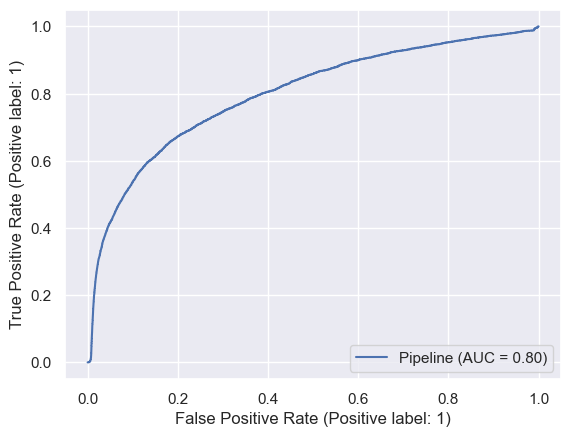

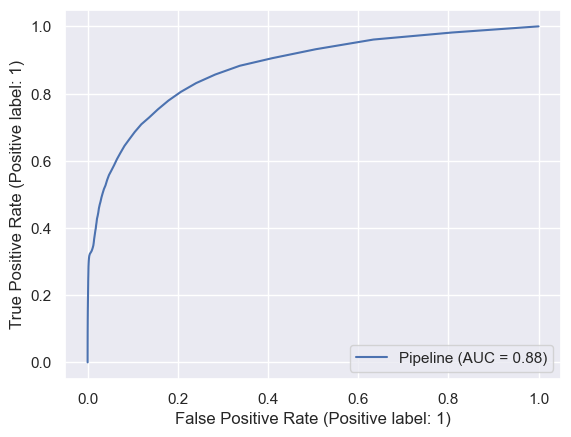

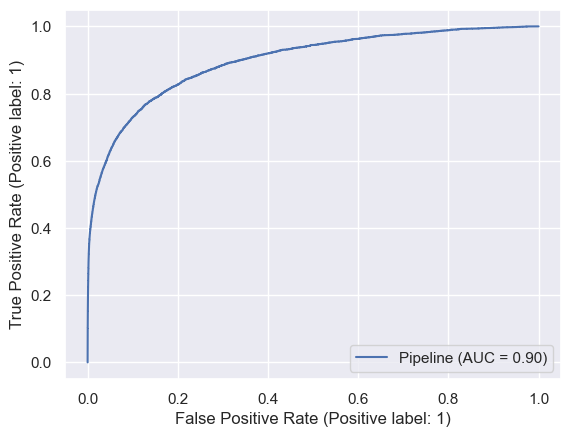

In [11]:
model_scores = fit_and_score_scaled(models=models,
                                    X_train=x_train,
                                    X_test=x_test,
                                    y_train=y_train,
                                    y_test=y_test)


In [12]:
model_scores[0]


{'Logistic Regression': 0.9584990009144173,
 'Random Forest': 0.9734412571544688,
 'Xgboost': 0.9743150336979713}

<AxesSubplot: >

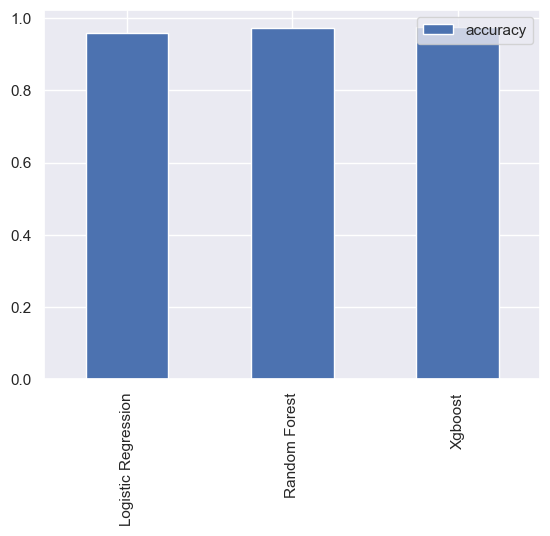

In [13]:
model_compare = pd.DataFrame(model_scores[0], index=['accuracy'])
model_compare.T.plot.bar()


## base model without standard scaler


In [14]:
# Create function to fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    model_classification = {}
    model_roc = {}
    # Loop through models
    for name, model in models.items():

        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)

        # Make preidctions on test data
        y_preds = model.predict(X_test)
        # Show classification report
        model_classification[name] = print(
            classification_report(y_test, y_preds))
        # plot roc curve
        model_roc[name] = plot_roc_curve(model, X_test, y_test)

    return model_scores, model_classification, model_roc


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.82      0.30      0.44      5100

    accuracy                           0.97    147635
   macro avg       0.90      0.65      0.71    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.34      0.48      5100

    accuracy                           0.97    147635
   macro avg       0.89      0.67      0.73    147635
weighted avg       0.97      0.97      0.97    147635



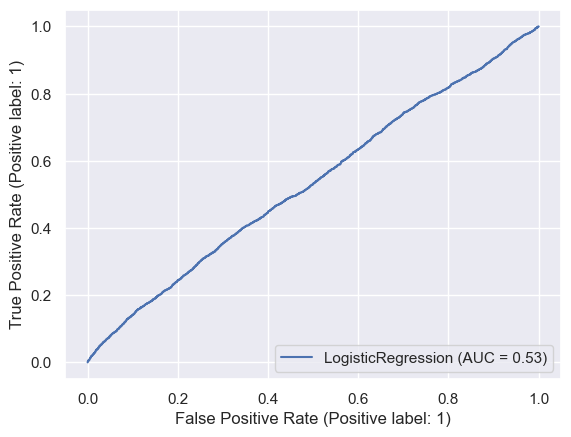

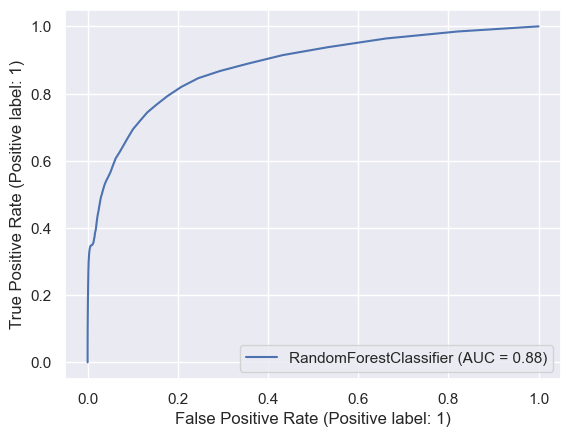

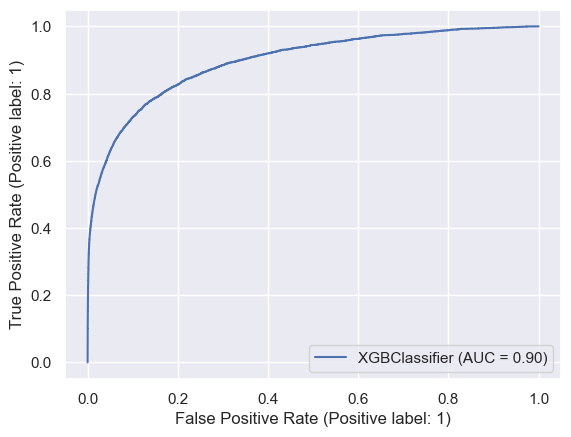

In [15]:
model_scores = fit_and_score(models=models,
                             X_train=x_train,
                             X_test=x_test,
                             y_train=y_train,
                             y_test=y_test)


In [16]:
model_scores[0]


{'Logistic Regression': 0.9654553459545501,
 'Random Forest': 0.9735970467707522,
 'Xgboost': 0.9743150336979713}

In [72]:
model_scores[1]

{'Logistic Regression': None, 'Random Forest': None, 'Xgboost': None}

## base models scaled and class imbalance smooth


In [17]:
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))


[(0, 427342), (1, 427342)]


              precision    recall  f1-score   support

           0       0.99      0.69      0.82    142535
           1       0.08      0.78      0.15      5100

    accuracy                           0.70    147635
   macro avg       0.54      0.73      0.48    147635
weighted avg       0.96      0.70      0.79    147635

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142535
           1       0.84      0.26      0.39      5100

    accuracy                           0.97    147635
   macro avg       0.91      0.63      0.69    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    142535
           1       0.39      0.55      0.45      5100

    accuracy                           0.95    147635
   macro avg       0.68      0.76      0.71    147635
weighted avg       0.96      0.95      0.96    147635



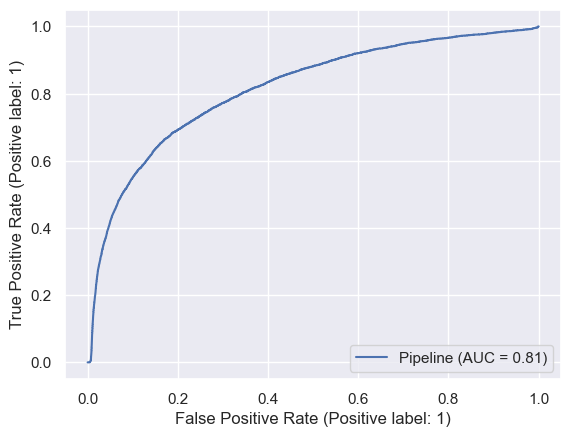

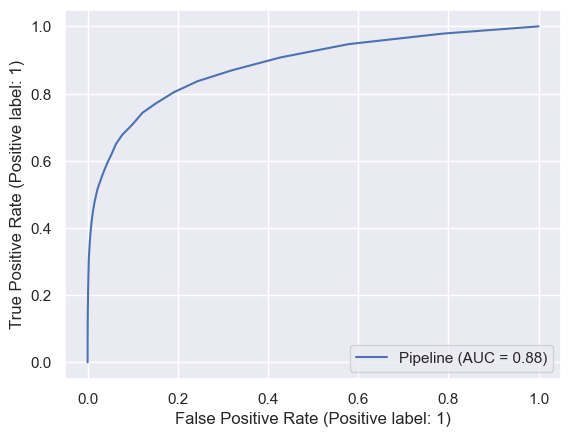

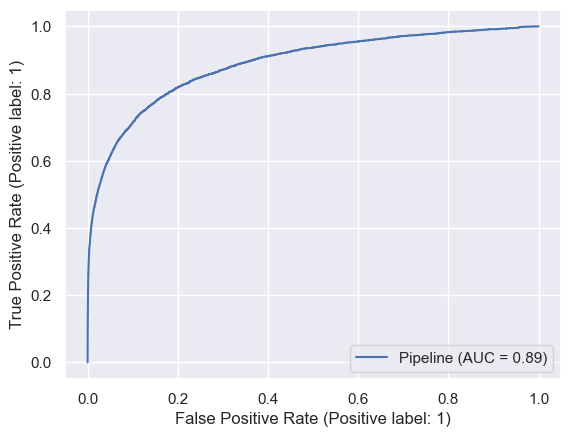

In [18]:
model = fit_and_score_scaled(X_train=X_resampled,
                             X_test=x_test,
                             y_train=y_resampled,
                             y_test=y_test,
                             models=models)


In [19]:
model[0]


{'Logistic Regression': 0.697456565177634,
 'Random Forest': 0.972628441765164,
 'Xgboost': 0.954136891658482}

## Neural network base model


In [29]:
classifier = MLPClassifier(hidden_layer_sizes=(
    10,5), max_iter=100, activation='relu', solver='adam', random_state=1)
NN_base = classifier.fit(x_train, y_train)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635



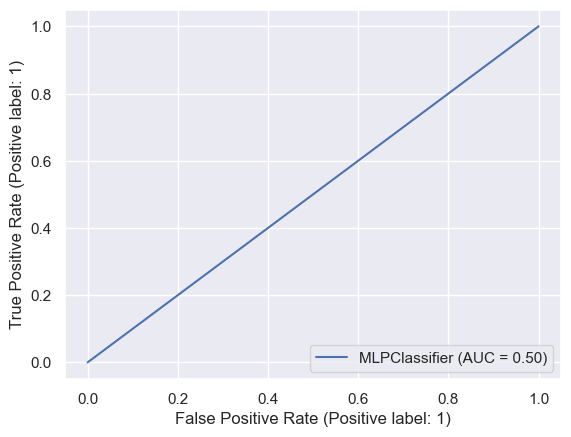

In [35]:
# Make preidctions on test data
y_preds = NN_base.predict(x_test)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(NN_base, x_test, y_test);
# Show classification report
print(classification_report(y_test, y_preds))

In [30]:
y_train_pred = NN_base.predict(x_train)
y_test_pred = NN_base.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, NN_base.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, NN_base.predict_proba(x_test)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.5
Area under test roc 0.5


## Neural network with scaled data


In [33]:
pipe = make_pipeline(
            StandardScaler(),
            MLPClassifier(hidden_layer_sizes=(
    10,5), max_iter=100, activation='relu', solver='adam', random_state=1)
        )
        # Fit the model to the data
pipe.fit(x_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=100,
                               random_state=1))])

In [34]:

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, pipe.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, pipe.predict_proba(x_test)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9007193243813114
Area under test roc 0.8334807728683082


              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.54      0.29      0.38      5100

    accuracy                           0.97    147635
   macro avg       0.76      0.64      0.68    147635
weighted avg       0.96      0.97      0.96    147635



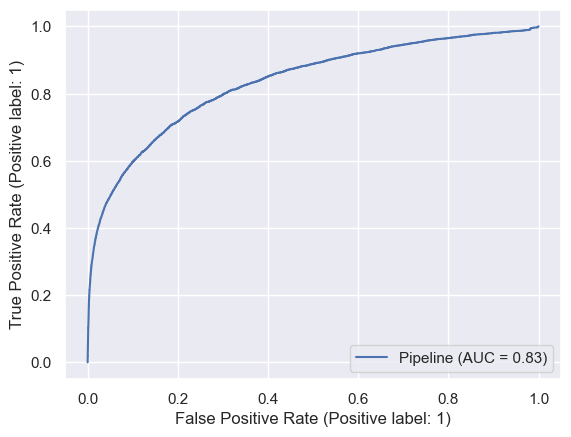

In [36]:
# Make preidctions on test data
y_preds = pipe.predict(x_test)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(pipe, x_test, y_test);
# Show classification report
print(classification_report(y_test, y_preds))

## neural Network with scaled and oversmapling class imbalance

In [37]:
pipe2 = make_pipeline(
            StandardScaler(),
            MLPClassifier(hidden_layer_sizes=(
    10,5), max_iter=100, activation='relu', solver='adam', random_state=1)
        )
        # Fit the model to the data
pipe2.fit(X_resampled, y_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=100,
                               random_state=1))])

In [41]:
y_train_pred = pipe2.predict(x_train)
y_test_pred = pipe2.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, pipe2.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, pipe2.predict_proba(x_test)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9252230597828551
Area under test roc 0.8280278493689543


In [52]:
def plot_confusion_matrix(data, preds, title):
    conf = confusion_matrix(data, preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt="0")
    plt.title(title)
    plt.show()

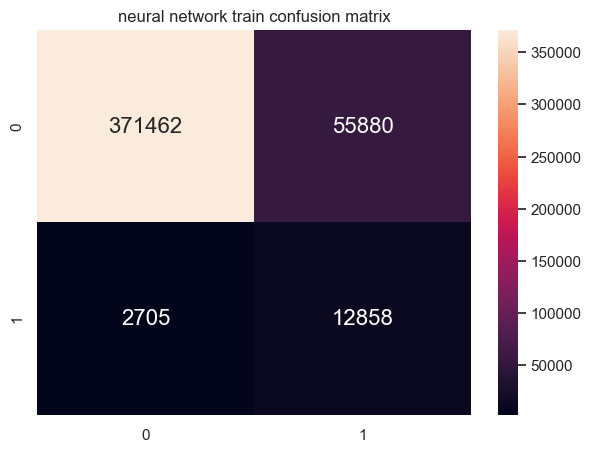

In [55]:
plot_confusion_matrix(y_train, y_train_pred, 'neural network train confusion matrix')

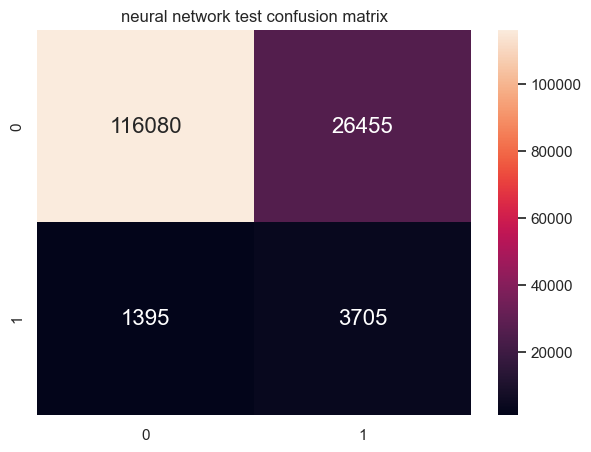

In [56]:
plot_confusion_matrix(y_test,y_test_pred, 'neural network test confusion matrix')

## XGBoost random search and oversampling

In [62]:
params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}

clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)


model = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='roc_auc', verbose=1, cv=3, n_iter=6)
model.fit(X_resampled, y_resampled)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.4,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=-1,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=6,
                   param_distributions={'max_depth': [3, 6, 12],
                                        'n_estimators': [1000, 2000],
                                        'subsample': [0.4, 0.8]},
                   scoring='roc_auc', verbose=1)

In [63]:
model.best_params_

{'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 12}

In [64]:
model = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,subsample=0.8)
model.fit(X_resampled, y_resampled)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9999977022048964
Area under test roc 0.9043664940912346


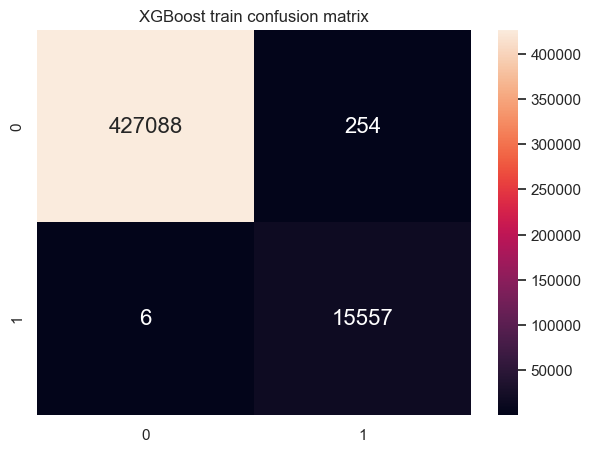

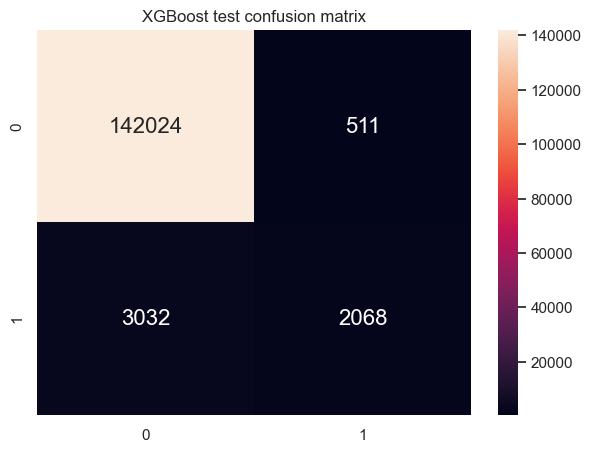

In [67]:
plot_confusion_matrix(y_train, y_train_pred, 'XGBoost train confusion matrix')
plot_confusion_matrix(y_test,y_test_pred, 'XGBoost test confusion matrix')

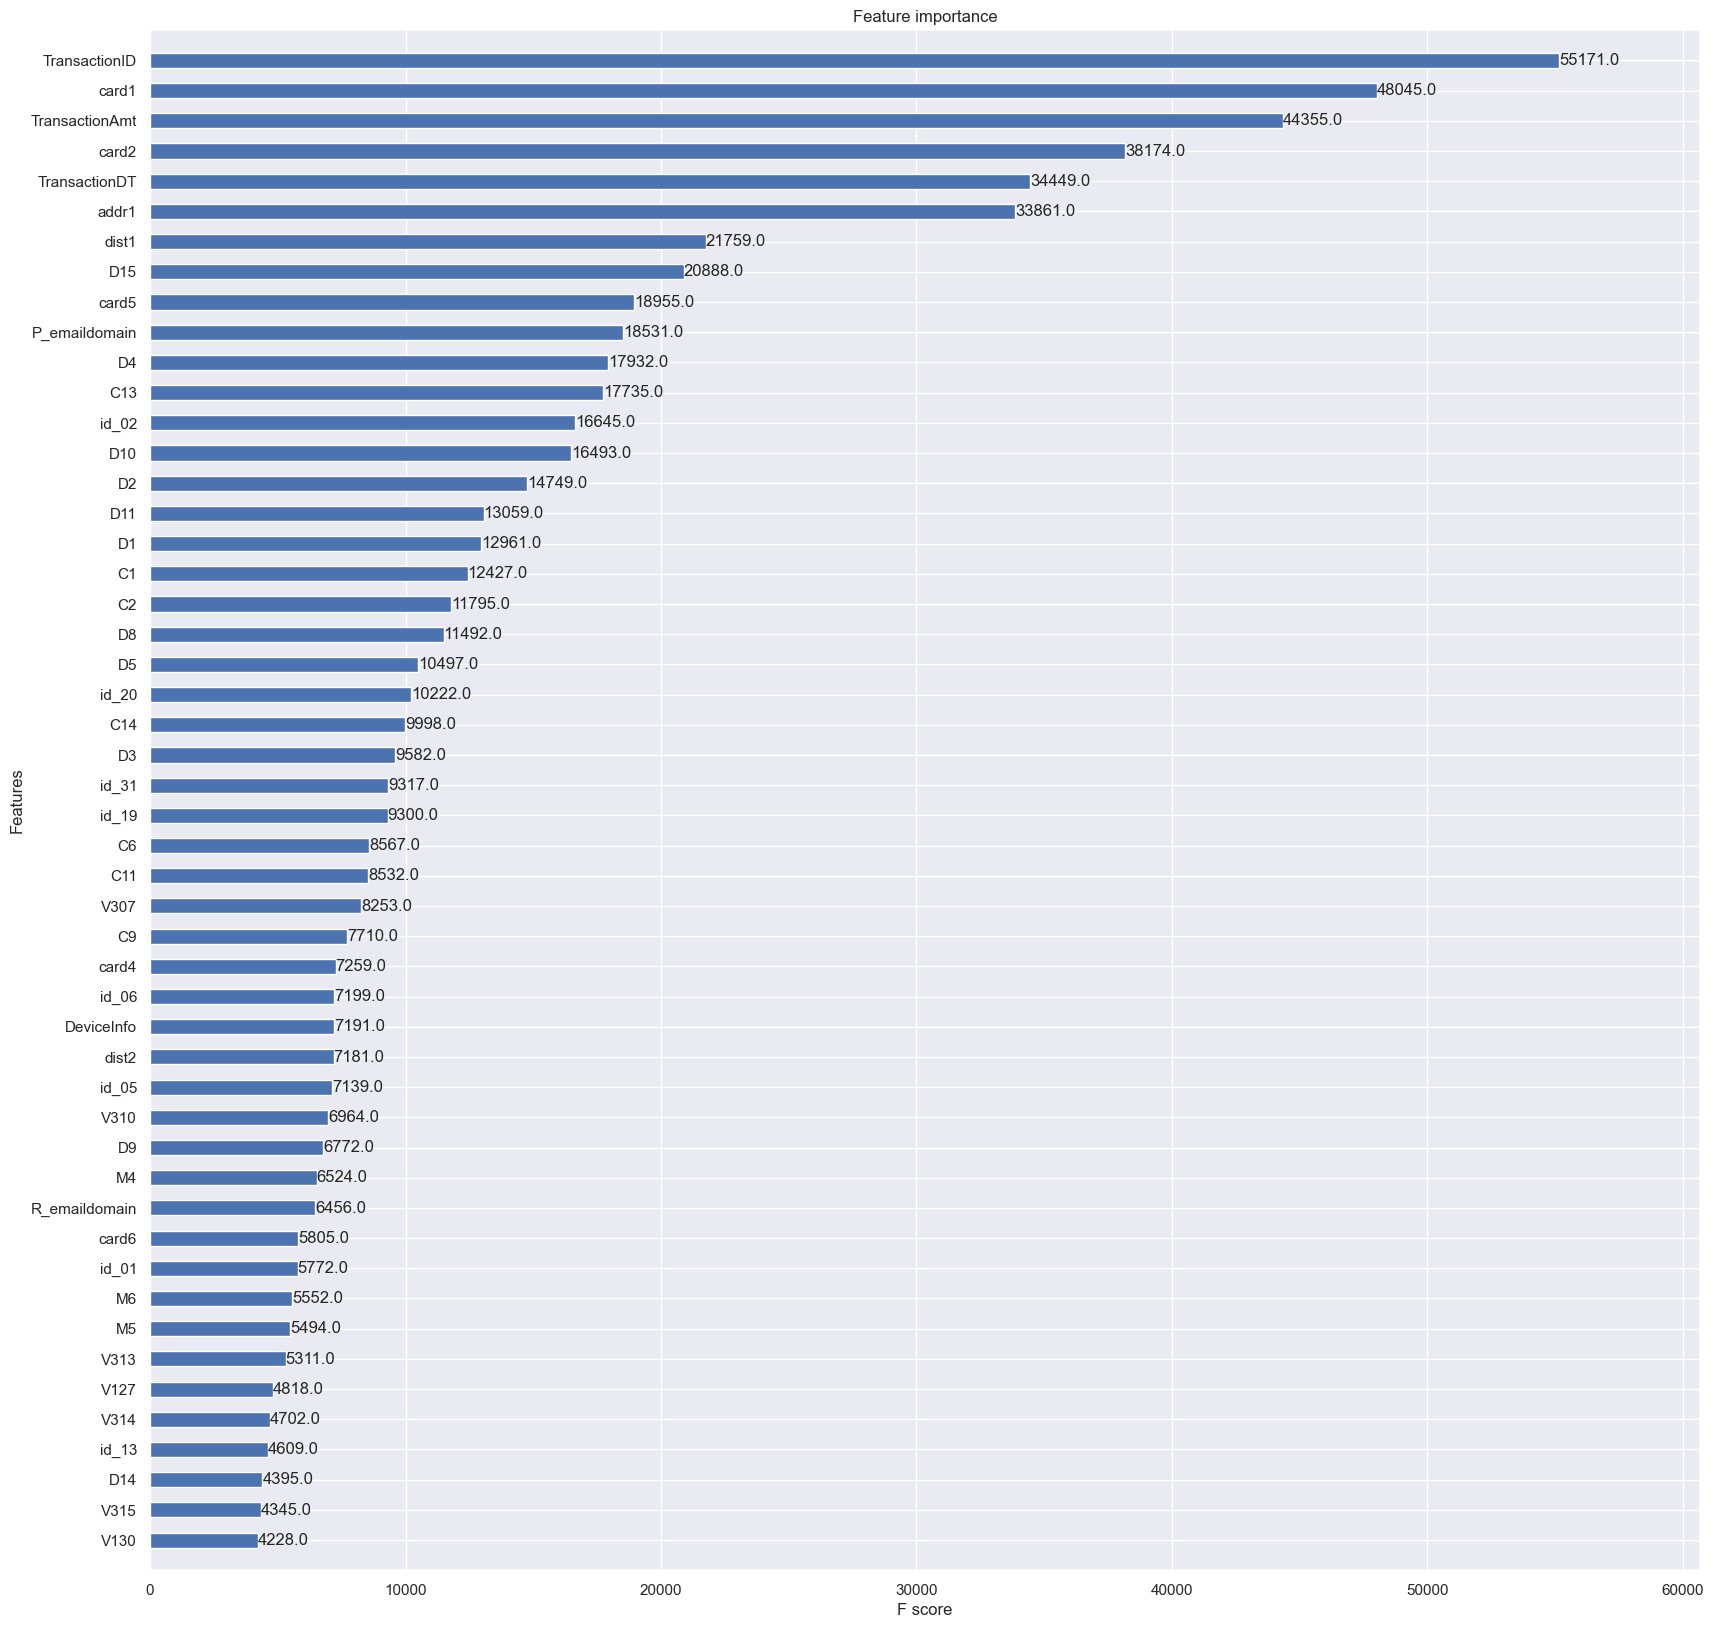

In [65]:
from xgboost import plot_importance
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()

In [75]:
params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}

clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)


model = GridSearchCV(clf, params, scoring='roc_auc', verbose=1, cv=3)
model.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.4,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=-1, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [3, 6, 12], 'n_estimators': [1000, 2000],
                         'subsample': [0.4, 0.8]},
             scoring='roc_auc', verbose=1)

In [76]:
model.best_params_

{'max_depth': 12, 'n_estimators': 2000, 'subsample': 0.8}

In [77]:
model = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,subsample=0.8)
model.fit(X_resampled, y_resampled)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

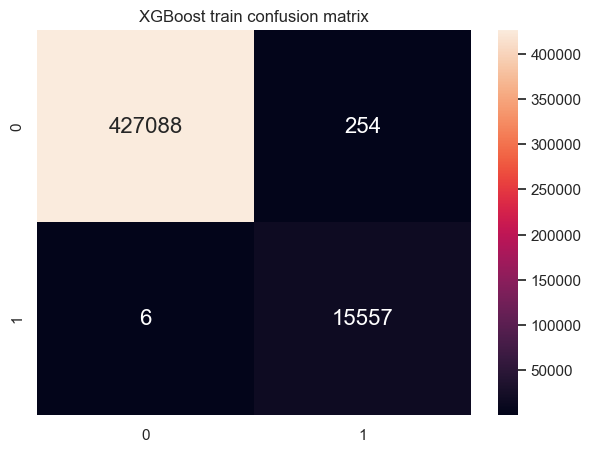

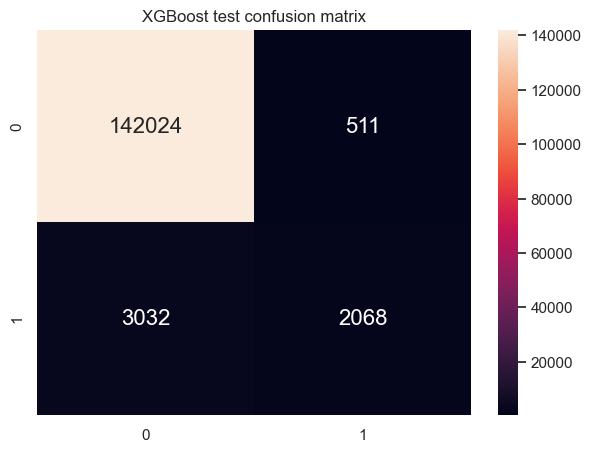

In [78]:
plot_confusion_matrix(y_train, y_train_pred, 'XGBoost train confusion matrix')
plot_confusion_matrix(y_test,y_test_pred, 'XGBoost test confusion matrix')

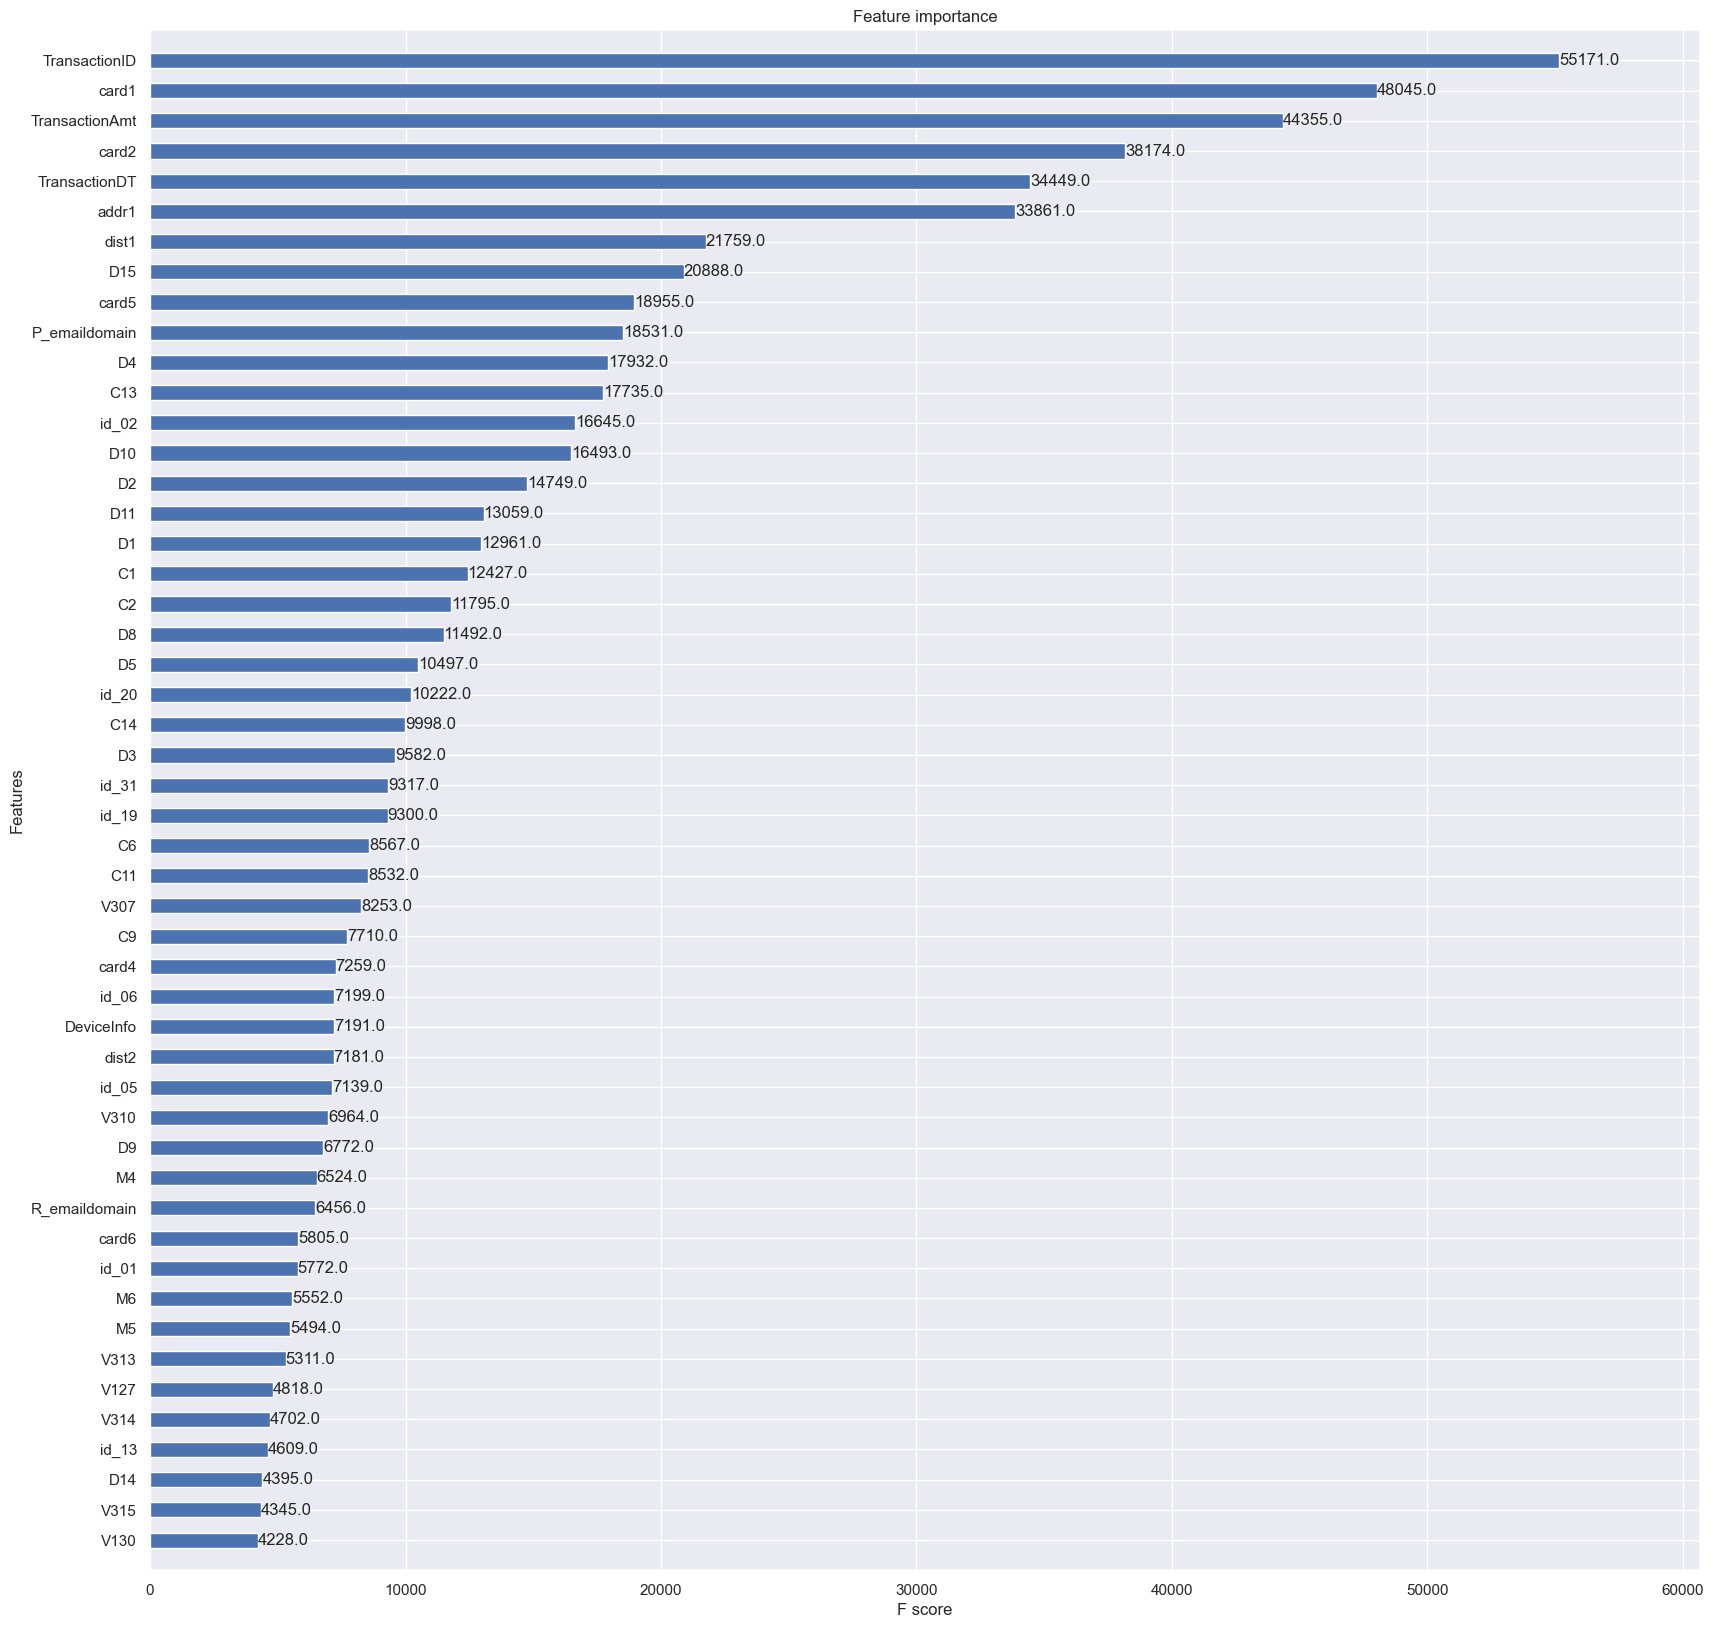

In [79]:
from xgboost import plot_importance
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
plot_importance(model,max_num_features=50,height=0.5,ax=axes)
plt.show()